# Notebook 4 — Monte Carlo from Implied PDF + Calendar-Arbitrage Check

This notebook:
1) Builds a risk-neutral Monte Carlo sampler from the implied PDF (Breeden–Litzenberger) using a cleaned call curve.
2) Checks **calendar arbitrage** across two nearby expiries using forward-moneyness normalization.
It runs offline by synthesizing two expiries if live data isn't available.


In [1]:
# %pip install numpy pandas scipy matplotlib yfinance nbformat
import numpy as np, pandas as pd, numpy.linalg as LA, matplotlib.pyplot as plt, math, warnings, datetime as dt
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda v: f'{v:,.6f}')
try:
    import yfinance as yf; HAVE_YF=True
except Exception:
    HAVE_YF=False
from scipy import interpolate
from pathlib import Path
DATA_DIR = Path('C:/Pcs/Python/new price project')

In [2]:
def fetch_chain_yf(ticker:str, expiry:str|None):
    if not HAVE_YF: return None
    try:
        tk = yf.Ticker(ticker); exps = tk.options
        if not exps: return None
        exp = expiry or exps[0]
        oc = tk.option_chain(exp)
        calls = oc.calls.copy()
        calls['call_mid']=(calls['bid'].fillna(0)+calls['ask'].fillna(0))/2
        calls = calls[['strike','call_mid']].rename(columns={'strike':'K'})
        calls['expiry']=exp
        return calls.sort_values('K').reset_index(drop=True)
    except Exception:
        return None

def infer_forward_discount(df: pd.DataFrame):
    # If no puts, approximate F via minimum slope change; D=1 for demo
    D = 1.0
    c = df['call_mid'].values; k = df['K'].values
    idx = np.nanargmin(np.abs(np.diff(c, prepend=c[0])))
    F = float(k[int(np.clip(idx,0,len(k)-1))])
    return float(F), float(D)

In [3]:
def synth_two_terms():
    # Create two synthetic expiries that always work offline
    S0=450.0; r=0.03; q=0.01
    def bs_call(S,K,r,q,sig,T):
        if T<=0 or sig<=0 or S<=0 or K<=0: return max(S*np.exp(-q*T)-K*np.exp(-r*T),0.0)
        d1=(np.log(S/K)+(r-q+0.5*sig**2)*T)/(sig*np.sqrt(T)); d2=d1-sig*np.sqrt(T)
        from math import erf, sqrt
        N=lambda x: 0.5*(1.0+erf(x/sqrt(2)))
        return S*np.exp(-q*T)*N(d1)-K*np.exp(-r*T)*N(d2)
    T1,T2=20/365.0,35/365.0; sig1,sig2=0.22,0.225
    Ks=np.arange(225.0,680.0,5.0)
    C1=np.array([bs_call(S0,K,r,q,sig1,T1) for K in Ks])
    C2=np.array([bs_call(S0,K,r,q,sig2,T2) for K in Ks])
    df1=pd.DataFrame({'expiry':[(dt.date.today()+dt.timedelta(days=20)).isoformat()]*len(Ks),'K':Ks,'call_mid':C1})
    df2=pd.DataFrame({'expiry':[(dt.date.today()+dt.timedelta(days=35)).isoformat()]*len(Ks),'K':Ks,'call_mid':C2})
    return df1, df2

In [4]:
def load_two_terms(ticker='SPY'):
    df1=df2=None
    if HAVE_YF:
        try:
            tk=yf.Ticker(ticker); exps=tk.options
            if exps and len(exps)>=2:
                df1=fetch_chain_yf(ticker, exps[0])
                df2=fetch_chain_yf(ticker, exps[1])
        except Exception:
            pass
    if df1 is None or df2 is None or df1.empty or df2.empty:
        df1, df2 = synth_two_terms()
    F1,D1 = infer_forward_discount(df1); F2,D2 = infer_forward_discount(df2)
    K1 = np.linspace(df1['K'].min(), df1['K'].max(), 181)
    K2 = np.linspace(df2['K'].min(), df2['K'].max(), 181)
    C1 = np.interp(K1, df1['K'].values, df1['call_mid'].values)
    C2 = np.interp(K2, df2['K'].values, df2['call_mid'].values)
    return (K1,C1,F1,D1,df1['expiry'].iloc[0]), (K2,C2,F2,D2,df2['expiry'].iloc[0])

In [5]:
def diff2_uniform(y, dx):
    y=np.asarray(y,float); n=len(y)
    if n<5: return np.zeros_like(y)
    ypad=np.empty(n+4); ypad[2:-2]=y
    ypad[1]=2*y[0]-y[1]; ypad[0]=2*ypad[1]-y[0]
    ypad[-2]=2*y[-1]-y[-2]; ypad[-1]=2*ypad[-2]-y[-1]
    return (ypad[0:-4]-2*ypad[1:-3]+ypad[2:-2])/(dx*dx)

def implied_pdf_from_call(K, C, D):
    dx=float(K[1]-K[0]); Cpp=diff2_uniform(C,dx); f=np.maximum(Cpp/max(D,1e-9),0.0)
    area=np.trapz(f,K); 
    if area<=0: return np.zeros_like(f), np.linspace(0,1,len(f))
    f=f/area; F=np.cumsum((f[:-1]+f[1:])*0.5*dx); F=np.concatenate([[0.0],F]); F=np.clip(F,0,1); return f,F

def mc_sample_from_pdf(K, cdf, n, seed=42):
    rng=np.random.default_rng(seed); u=rng.random(n); return np.interp(u, cdf, K)

In [6]:
# Build two terms & PDFs
term1, term2 = load_two_terms('SPY')
K1,C1,F1,D1,E1 = term1
K2,C2,F2,D2,E2 = term2
f1,cdf1 = implied_pdf_from_call(K1,C1,D1)
f2,cdf2 = implied_pdf_from_call(K2,C2,D2)
print(f"Expiry1={E1} F1={F1:.2f} D1={D1:.6f} | Expiry2={E2} F2={F2:.2f} D2={D2:.6f}")

Expiry1=2025-09-15 F1=570.00 D1=1.000000 | Expiry2=2025-09-16 F2=570.00 D2=1.000000


In [7]:
# Monte Carlo pricing helper
def payoff_fn(name,S,params,F_T):
    name=str(name).lower()
    if name=='digital':
        K0=float(params.get('K0',F_T)); return (S>K0).astype(float)
    if name=='call':
        K0=float(params.get('K0',F_T)); return np.maximum(S-K0,0.0)
    if name=='capped_call':
        K0=float(params.get('K0',F_T)); M=float(params.get('M',20.0)); return np.minimum(np.maximum(S-K0,0.0), M)
    if name=='log':
        return np.log(np.maximum(S,1e-9)/max(F_T,1e-9))
    raise ValueError('unknown payoff')

def mc_price(payoff, params, K, cdf, D, F_T, N=50000, seed=7):
    ST = mc_sample_from_pdf(K, cdf, N, seed=seed)
    g  = payoff_fn(payoff, ST, params, F_T)
    return D*float(np.mean(g)), dict(N=N, se=float(np.std(g)/np.sqrt(N)))

p, stats = mc_price('digital', {'K0':F1}, K1, cdf1, D1, F1, N=60000, seed=11)
print(f"MC price T1, digital @ATM: {p:.6f} (SE~{stats['se']:.6f} on undiscounted)")

MC price T1, digital @ATM: 1.000000 (SE~0.000000 on undiscounted)


In [8]:
# Calendar-arb check: normalized c(T,x) = C(T, x*F_T)/D(T)
def calendar_check(K1,C1,F1,D1, K2,C2,F2,D2, x_min=0.7, x_max=1.3, n=161):
    x1 = np.linspace(K1.min()/F1, K1.max()/F1, len(K1))
    x2 = np.linspace(K2.min()/F2, K2.max()/F2, len(K2))
    lo=max(x_min, x1.min(), x2.min()); hi=min(x_max, x1.max(), x2.max())
    if hi<=lo: raise ValueError('No overlap in forward-moneyness.')
    x = np.linspace(lo, hi, n)
    c1 = np.interp(x*F1, K1, C1)/max(D1,1e-9)
    c2 = np.interp(x*F2, K2, C2)/max(D2,1e-9)
    diff = c2 - c1
    report = dict(x_min=float(lo), x_max=float(hi),
                  max_violation=float(np.max(np.maximum(-diff,0.0))),
                  L1_violation=float(np.trapz(np.maximum(-diff,0.0), x)),
                  share_violations=float(np.mean(diff< -1e-8)))
    return x,c1,c2,diff,report

x,c1,c2,diff,report = calendar_check(K1,C1,F1,D1, K2,C2,F2,D2)
print('Calendar report:', report)

Calendar report: {'x_min': 1.0, 'x_max': 1.2456140350877194, 'max_violation': 0.0, 'L1_violation': 0.0, 'share_violations': 0.0}


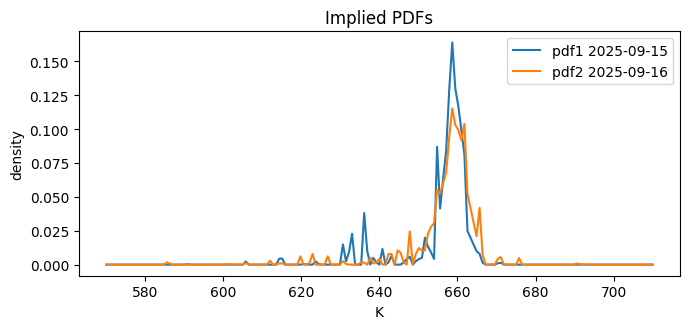

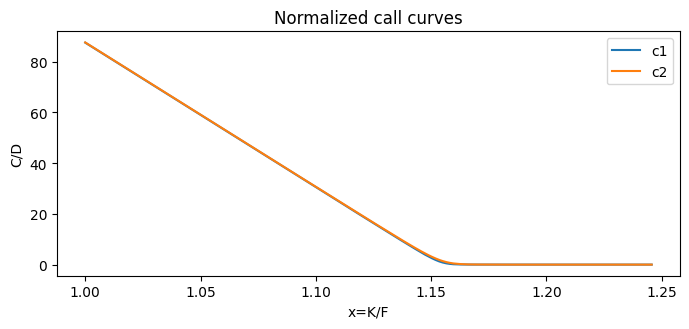

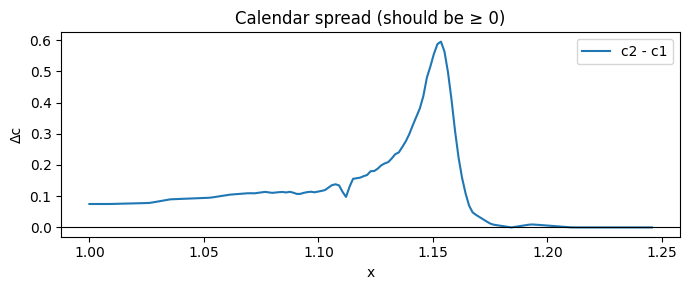

In [9]:
# Simple plots
import matplotlib.pyplot as plt
plt.figure(figsize=(7,3.4)); plt.plot(K1,f1,label=f'pdf1 {E1}'); plt.plot(K2,f2,label=f'pdf2 {E2}')
plt.title('Implied PDFs'); plt.xlabel('K'); plt.ylabel('density'); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(7,3.4)); plt.plot(x,c1,label='c1'); plt.plot(x,c2,label='c2')
plt.title('Normalized call curves'); plt.xlabel('x=K/F'); plt.ylabel('C/D'); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(7,3.0)); plt.plot(x,diff,label='c2 - c1'); plt.axhline(0,color='k',lw=0.8)
plt.title('Calendar spread (should be ≥ 0)'); plt.xlabel('x'); plt.ylabel('Δc'); plt.legend(); plt.tight_layout(); plt.show()